Escreva um programa que compare um sistema de paginação usando o algoritmo FIFO com o algoritmo de envelhecimento. O número de molduras de páginas é um parâmetro. A sequência de referências de páginas deve ser organizada simulando conjuntos de trabalho de processos. Cada conjunto de trabalho deve representar o comportamento típico de acesso a páginas de memória de um processo e pode variar em tamanho e duração.
Simule diferentes processos com tamanho e duração de conjuntos de trabalho distintos e anote as sequências de referências geradas em um arquivo para conferência. Para cada um dos processos simulados, analise o número de faltas de página por 1000 referências de memória como função do número de molduras de páginas disponíveis.

##**SETUP E DEFINIÇÕES GERAIS**






In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define um seed global para garantir a reprodutibilidade dos resultados
random.seed(42)

# Algoritmos de Substituição

class AlgoritmoFIFO:
    def __init__(self, num_molduras):
        if num_molduras <= 0:
            raise ValueError("O número de molduras deve ser positivo.")
        self.num_molduras = num_molduras
        self.molduras = []
        self.faltas_de_pagina = 0

    def acessar_pagina(self, pagina):
        if pagina in self.molduras:
            return

        self.faltas_de_pagina += 1

        if len(self.molduras) < self.num_molduras:
            self.molduras.append(pagina)
        else:
            self.molduras.pop(0)
            self.molduras.append(pagina)

class AlgoritmoEnvelhecimento:
    def __init__(self, num_molduras, num_bits_contador=8):
        if num_molduras <= 0:
            raise ValueError("O número de molduras deve ser positivo.")
        self.num_molduras = num_molduras
        self.num_bits_contador = num_bits_contador
        self.molduras = []
        self.faltas_de_pagina = 0
        self.msb = 1 << (num_bits_contador - 1)

    def _envelhecer_paginas(self):
        for i in range(len(self.molduras)):
            self.molduras[i][1] >>= 1

    def acessar_pagina(self, pagina):
        self._envelhecer_paginas()

        indice_pagina = -1
        for i, (p, _) in enumerate(self.molduras):
            if p == pagina:
                indice_pagina = i
                break

        if indice_pagina != -1:
            self.molduras[indice_pagina][1] |= self.msb
            return

        self.faltas_de_pagina += 1
        nova_pagina_com_contador = [pagina, self.msb]

        if len(self.molduras) < self.num_molduras:
            self.molduras.append(nova_pagina_com_contador)
        else:
            indice_para_substituir = 0
            menor_contador = self.molduras[0][1]
            for i in range(1, len(self.molduras)):
                if self.molduras[i][1] < menor_contador:
                    menor_contador = self.molduras[i][1]
                    indice_para_substituir = i
            self.molduras[indice_para_substituir] = nova_pagina_com_contador

# Gerador de Sequências de Referências

def gerar_sequencia_cenario1(num_referencias, num_paginas_total, processos_config):
    sequencia = []
    processos_ws_atual = {}
    for p_conf in processos_config:
        pid, ws_size = p_conf['id'], p_conf['ws_size']
        inicio_ws = random.randint(0, num_paginas_total - ws_size)
        processos_ws_atual[pid] = list(range(inicio_ws, inicio_ws + ws_size))
    contadores_duracao = {p_conf['id']: 0 for p_conf in processos_config}
    for i in range(num_referencias):
        p_escolhido_conf = random.choice(processos_config)
        pid, ws_size, ws_duration = p_escolhido_conf['id'], p_escolhido_conf['ws_size'], p_escolhido_conf['ws_duration']
        contadores_duracao[pid] += 1
        if contadores_duracao[pid] >= ws_duration:
            contadores_duracao[pid] = 0
            inicio_ws = random.randint(0, num_paginas_total - ws_size)
            processos_ws_atual[pid] = list(range(inicio_ws, inicio_ws + ws_size))
        if random.random() < 0.90:
            pagina_referenciada = random.choice(processos_ws_atual[pid])
        else:
            pagina_referenciada = random.randint(0, num_paginas_total - 1)
        sequencia.append(pagina_referenciada)
    return sequencia

def gerar_sequencia_cenario2(num_referencias, num_paginas_total, ws_config, scan_config):
    sequencia = []
    ws_paginas = list(range(ws_config['inicio'], ws_config['inicio'] + ws_config['tamanho']))
    inicio_scan = ws_config['inicio'] + ws_config['tamanho']
    fim_scan = inicio_scan + scan_config['tamanho']
    if fim_scan > num_paginas_total:
        raise ValueError("Configuração de scan excede o número total de páginas.")
    paginas_scan = list(range(inicio_scan, fim_scan))
    i = 0
    while i < num_referencias:
        if random.random() < scan_config['chance']:
            for pagina_scan in paginas_scan:
                if i < num_referencias:
                    sequencia.append(pagina_scan)
                    i += 1
        else:
            if random.random() < 0.95:
                pagina_referenciada = random.choice(ws_paginas)
            else:
                pagina_referenciada = random.randint(0, num_paginas_total - 1)
            if i < num_referencias:
                sequencia.append(pagina_referenciada)
                i += 1
    return sequencia

def analisar_curva_execucao(sequencia, n_molduras_fixo):
    sim_fifo = AlgoritmoFIFO(n_molduras_fixo)
    faltas_acum_fifo = []
    for pagina in sequencia:
        sim_fifo.acessar_pagina(pagina)
        faltas_acum_fifo.append(sim_fifo.faltas_de_pagina)
    sim_aging = AlgoritmoEnvelhecimento(n_molduras_fixo)
    faltas_acum_aging = []
    for pagina in sequencia:
        sim_aging.acessar_pagina(pagina)
        faltas_acum_aging.append(sim_aging.faltas_de_pagina)
    return faltas_acum_fifo, faltas_acum_aging

print("Célula de Setup executada. Classes e funções foram definidas.")

Célula de Setup executada. Classes e funções foram definidas.


##**SIMULAÇÃO E ANÁLISE DO CENÁRIO 1 (MÚLTIPLOS PROCESSOS)**

--- Iniciando Experimento: Cenário 1 (Múltiplos Processos) ---
Sequência de 50000 referências gerada para o Cenário 1.

Resultados da Simulação - Cenário 1:
   num_molduras  FIFO_total_faltas  Envelhecimento_total_faltas
0             5              43495                        43391
1            10              37466                        38373
2            15              31894                        36113
3            20              26826                        33690
4            25              22319                        31191
5            30              18380                        29028
6            35              15053                        26460
7            40              12335                        24172
8            45              10058                        22486
9            50               8209                        20122

Gerando gráficos para o Cenário 1...


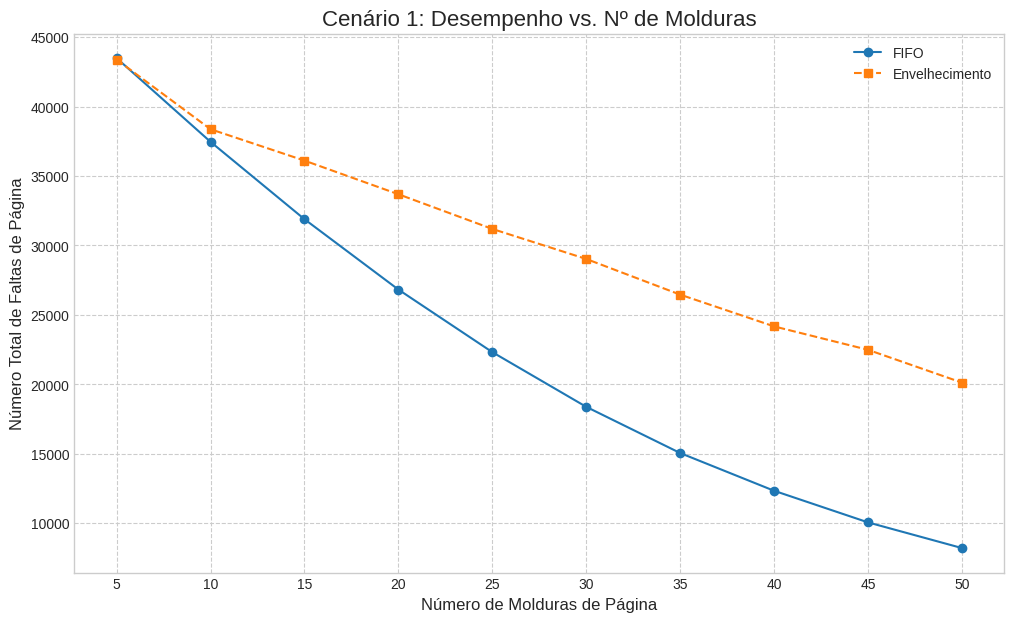

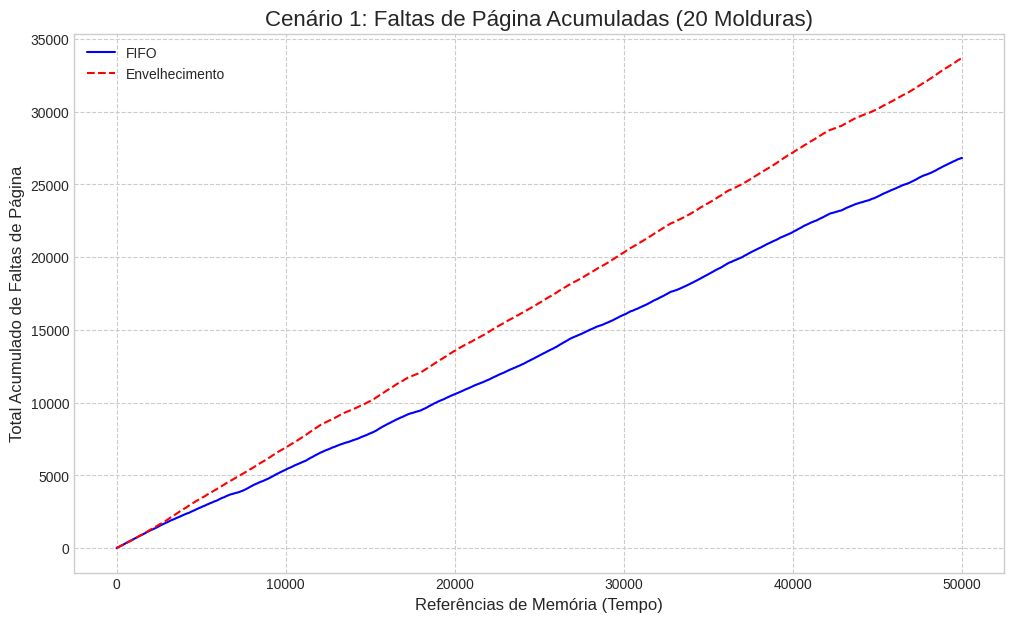

In [ ]:
print("--- Iniciando Experimento: Cenário 1 (Múltiplos Processos) ---")

# --- Parâmetros ---
config_processos_cenario1 = [
    {'id': 1, 'ws_size': 10, 'ws_duration': 250},
    {'id': 2, 'ws_size': 25, 'ws_duration': 1000},
    {'id': 3, 'ws_size': 15, 'ws_duration': 500}
]
sequencia_cenario1 = gerar_sequencia_cenario1(50000, 100, config_processos_cenario1)
print(f"Sequência de {len(sequencia_cenario1)} referências gerada para o Cenário 1.")

# --- Simulação ---
faixa_molduras = list(range(5, 51, 5))
resultados_cenario1 = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for pagina in sequencia_cenario1: sim_fifo.acessar_pagina(pagina)

    sim_aging = AlgoritmoEnvelhecimento(n_molduras)
    for pagina in sequencia_cenario1: sim_aging.acessar_pagina(pagina)

    resultados_cenario1.append({
        "num_molduras": n_molduras,
        "FIFO_total_faltas": sim_fifo.faltas_de_pagina,
        "Envelhecimento_total_faltas": sim_aging.faltas_de_pagina
    })

df_resultados_cenario1 = pd.DataFrame(resultados_cenario1)
print("\nResultados da Simulação - Cenário 1:")
print(df_resultados_cenario1)

# --- Visualização dos Resultados ---
print("\nGerando gráficos para o Cenário 1...")
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico 1: Comparação de Desempenho
plt.figure(figsize=(12, 7))
plt.plot(df_resultados_cenario1['num_molduras'], df_resultados_cenario1['FIFO_total_faltas'], marker='o', linestyle='-', label='FIFO')
plt.plot(df_resultados_cenario1['num_molduras'], df_resultados_cenario1['Envelhecimento_total_faltas'], marker='s', linestyle='--', label='Envelhecimento')
plt.title('Cenário 1: Desempenho vs. Nº de Molduras', fontsize=16)
plt.xlabel('Número de Molduras de Página', fontsize=12)
plt.ylabel('Número Total de Faltas de Página', fontsize=12)
plt.xticks(faixa_molduras)
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

# Gráfico 2: Faltas Acumuladas
faltas_fifo_acum, faltas_aging_acum = analisar_curva_execucao(sequencia_cenario1, n_molduras_fixo=20)
plt.figure(figsize=(12, 7))
plt.plot(range(len(sequencia_cenario1)), faltas_fifo_acum, label='FIFO', color='blue')
plt.plot(range(len(sequencia_cenario1)), faltas_aging_acum, label='Envelhecimento', color='red', linestyle='--')
plt.title('Cenário 1: Faltas de Página Acumuladas (20 Molduras)', fontsize=16)
plt.xlabel('Referências de Memória (Tempo)', fontsize=12)
plt.ylabel('Total Acumulado de Faltas de Página', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

#**SIMULAÇÃO E ANÁLISE DO CENÁRIO 2 (SCAN DE MEMÓRIA)**

--- Iniciando Experimento: Cenário 2 (Scan de Memória) ---
Sequência de 50000 referências gerada para o Cenário 2.

Resultados da Simulação - Cenário 2:
   num_molduras  FIFO_total_faltas  Envelhecimento_total_faltas
0             5              37604                        37537
1            10              26125                        25575
2            15              17797                        18217
3            20              14083                        14772
4            25              12830                        13845
5            30              12292                        12181
6            35              11601                         9965
7            40              10690                         9039
8            45               8242                         3637
9            50               5225                         2074

Gerando gráficos para o Cenário 2...


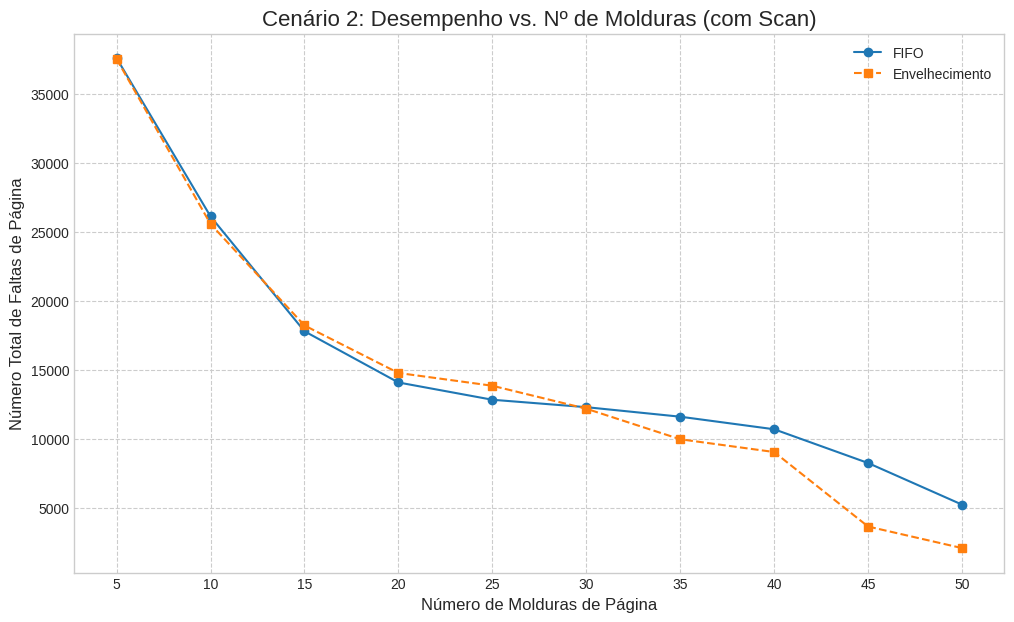

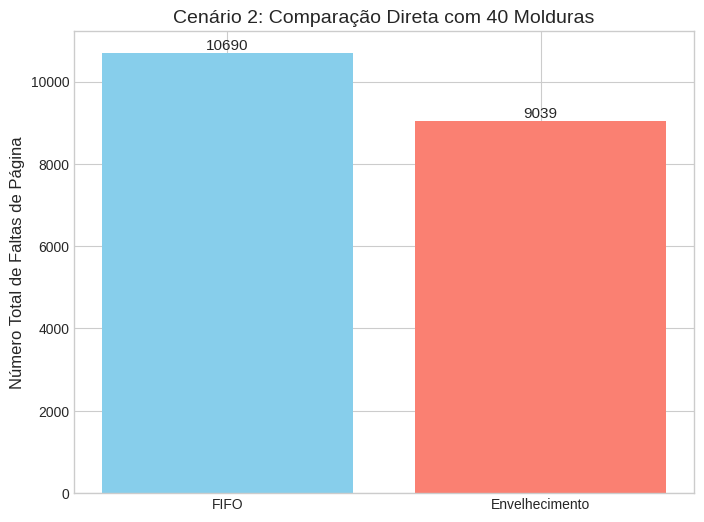

In [ ]:
print("--- Iniciando Experimento: Cenário 2 (Scan de Memória) ---")

# --- Parâmetros ---
ws_config_cenario2 = {'tamanho': 15, 'inicio': 10}
scan_config_cenario2 = {'tamanho': 30, 'chance': 0.005}
sequencia_cenario2 = gerar_sequencia_cenario2(50000, 100, ws_config_cenario2, scan_config_cenario2)
print(f"Sequência de {len(sequencia_cenario2)} referências gerada para o Cenário 2.")

# --- Simulação ---
faixa_molduras = list(range(5, 51, 5))
resultados_cenario2 = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for pagina in sequencia_cenario2: sim_fifo.acessar_pagina(pagina)

    sim_aging = AlgoritmoEnvelhecimento(n_molduras)
    for pagina in sequencia_cenario2: sim_aging.acessar_pagina(pagina)

    resultados_cenario2.append({
        "num_molduras": n_molduras,
        "FIFO_total_faltas": sim_fifo.faltas_de_pagina,
        "Envelhecimento_total_faltas": sim_aging.faltas_de_pagina
    })

df_resultados_cenario2 = pd.DataFrame(resultados_cenario2)
print("\nResultados da Simulação - Cenário 2:")
print(df_resultados_cenario2)

# --- Visualização dos Resultados ---
print("\nGerando gráficos para o Cenário 2...")
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico 1: Comparação de Desempenho
plt.figure(figsize=(12, 7))
plt.plot(df_resultados_cenario2['num_molduras'], df_resultados_cenario2['FIFO_total_faltas'], marker='o', linestyle='-', label='FIFO')
plt.plot(df_resultados_cenario2['num_molduras'], df_resultados_cenario2['Envelhecimento_total_faltas'], marker='s', linestyle='--', label='Envelhecimento')
plt.title('Cenário 2: Desempenho vs. Nº de Molduras (com Scan)', fontsize=16)
plt.xlabel('Número de Molduras de Página', fontsize=12)
plt.ylabel('Número Total de Faltas de Página', fontsize=12)
plt.xticks(faixa_molduras)
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

# Gráfico 2: Comparação Direta (adicionado para padronização)
ponto_de_comparacao = 40 # Usando 40 molduras como exemplo
dados_ponto = df_resultados_cenario2[df_resultados_cenario2['num_molduras'] == ponto_de_comparacao].iloc[0]
plt.figure(figsize=(8, 6))
bars = plt.bar(['FIFO', 'Envelhecimento'], [dados_ponto['FIFO_total_faltas'], dados_ponto['Envelhecimento_total_faltas']], color=['skyblue', 'salmon'])
plt.ylabel('Número Total de Faltas de Página', fontsize=12)
plt.title(f'Cenário 2: Comparação Direta com {ponto_de_comparacao} Molduras', fontsize=14)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=11)
plt.show()